# `true-intent` Destination Classification

We provide 3 benchmarks for the 7-class multi-class classification of `destination` column in `truevoice-intnet` dataset: [fastText](https://github.com/facebookresearch/fastText), LinearSVC and [ULMFit](https://github.com/cstorm125/thai2fit). In the transfer learning cases, we first finetune the embeddings using all data. The test set contains 20% of all data split by [TrueVoice](http://www.truevoice.co.th/). The rest is split into 85/15 train-validation split randomly. Performance metrics are micro-averaged accuracy and F1 score.

| model     | accuracy | micro-F1 |
|-----------|----------|----------|
| fastText  | 0.384116 | 0.384116 |
| LinearSVC | 0.807876 | 0.327565 |
| **ULMFit**    | **0.834981**  | **0.834981** |

In [79]:
import pandas as pd
import numpy as np
from pythainlp import word_tokenize
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

def replace_newline(t):
    return re.sub('[\n]{1,}', ' ', t)

ft_data = 'ft_data/'

y = 'destination'
nb_class = 7

In [80]:
import string
import emoji
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    
    #tokenize
    res = [word for word in res.split('|') if word and not re.search(pattern=r"\s+", string=word)]
    
    #post rules
    res = ungroup_emoji(res)
    
    return res

## Train-validation-test Split

We perform 85/15 train-validation split in addition to the test split by [TrueVoice](http://www.truevoice.co.th/).

In [81]:
from sklearn.model_selection import train_test_split
all_df = pd.read_csv(f'mari_train.csv')
all_df['destination'] = all_df.destination.map(lambda x: x.replace(' ','_'))
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = pd.read_csv(f'mari_test.csv')
test_df['destination'] = test_df.destination.map(lambda x: x.replace(' ','_'))
print(train_df.shape, valid_df.shape, test_df.shape)

(10998, 5) (1941, 5) (3236, 5)


In [82]:
#test set prevalence
test_df['destination'].value_counts() / test_df.shape[0]

billing_and_payment      0.301916
internet                 0.190049
promotions               0.182324
other_queries            0.169654
international_dialing    0.062732
lost_and_stolen          0.060569
true_money               0.032756
Name: destination, dtype: float64

## [fastText](https://github.com/facebookresearch/fastText) Model

We used embeddings pretrained on [Thai Wikipedia Dump](https://github.com/facebookresearch/fastText/blob/master/docs/pretrained-vectors.md) and finetuned them using all of `truevoice-intent` using skipgram model. After that, we do a multi-class classification and compute performance metrics.

In [85]:
df_txts = ['train','valid','test']
dfs = [train_df,valid_df,test_df]

for i in range(3):
    df = dfs[i]
    ft_lines = []
    for _,row in df.iterrows():
        ft_lab = f'__label__{row[y]}'
        ft_text = replace_newline(f'{row["texts"]}')
        ft_line = f'{ft_lab} {ft_text}'
        ft_lines.append(ft_line)

    doc = '\n'.join(ft_lines)
    with open(f'{ft_data}{df_txts[i]}.txt','w') as f:
        f.write(doc)
    f.close()

In [ ]:
#for fasttext embedding finetuning
ft_lines = []
for _,row in all_df.iterrows():
    ft_lab = '__label__0'
    ft_text = replace_newline(f'{row["texts"]}')
    ft_line = f'{ft_lab} {ft_text}'
    ft_lines.append(ft_line)

doc = '\n'.join(ft_lines)
with open(f'{ft_data}df_all.txt','w') as f:
    f.write(doc)
f.close()

In [72]:
#finetune with all data
!/home/charin/fastText-0.1.0/fasttext skipgram \
-pretrainedVectors 'model/wiki.th.vec' -dim 300 \
-input ft_data/df_all.txt -output 'model/finetuned'

/bin/sh: 1: /home/charin/fastText-0.1.0/fasttext: not found


In [73]:
#train classifier
!/home/charin/fastText-0.1.0/fasttext supervised \
-input 'ft_data/train.txt' -output 'model/classifier' \
-pretrainedVectors 'model/finetuned.vec' -epoch 5 -dim 300 -wordNgrams 2 

/bin/sh: 1: /home/charin/fastText-0.1.0/fasttext: not found


In [74]:
#get prediction
preds = !/home/charin/fastText-0.1.0/fasttext predict 'model/classifier.bin' 'ft_data/test.txt'

In [75]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
pred_lab = np.array([i[9:] for i in preds])

enc_fit = enc.fit(test_df[y][:,None])
pred_ohe = enc_fit.transform(pred_lab[:,None]).toarray()
y_ohe = enc_fit.transform(test_df[y][:,None]).toarray()

In [78]:
import warnings
warnings.filterwarnings("ignore")
#macro metrics
for i in range(nb_class):
    print(
        (pred_ohe[:,i]==y_ohe[:,i]).mean(),
        f1_score(pred_ohe[:,i],y_ohe[:,i]),
        precision_score(pred_ohe[:,i],y_ohe[:,i]),
        recall_score(pred_ohe[:,i],y_ohe[:,i])
         )

In [ ]:
print('micro metrics')
(pred_lab==test_df[y]).mean(), \
f1_score(test_df[y],pred_lab,average='micro'), \
precision_score(test_df[y],pred_lab,average='micro'), \
recall_score(test_df[y],pred_lab,average='micro')

## LinearSVC Model

Code for LinearSVC is provided by [@lukkiddd](https://github.com/lukkiddd).

In [ ]:
X_train, y_train = train_df['texts'], train_df[y]
X_test, y_test = test_df['texts'], test_df[y]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2))),
    ('clf', LinearSVC()),
])

text_clf.fit(X_train, y_train)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
pred_lab = text_clf.predict(X_test)

enc_fit = enc.fit(test_df[y][:,None])
pred_ohe = enc_fit.transform(pred_lab[:,None]).toarray()
y_ohe = enc_fit.transform(test_df[y][:,None]).toarray()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#macro metrics
for i in range(nb_class):
    print(
        (pred_ohe[:,i]==y_ohe[:,i]).mean(),
        f1_score(pred_ohe[:,i],y_ohe[:,i]),
        precision_score(pred_ohe[:,i],y_ohe[:,i]),
        recall_score(pred_ohe[:,i],y_ohe[:,i])
         )

In [ ]:
print('micro metrics')
(pred_ohe==y_ohe).mean(), \
f1_score(y_ohe,pred_ohe,average='micro'), \
precision_score(y_ohe,pred_ohe,average='micro'), \
recall_score(y_ohe,pred_ohe,average='micro')

## [ULMFit](https://github.com/cstorm125/thai2fit) Model

In [22]:
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback

from pythainlp.ulmfit import *

model_path = 'truevoice_data/'

In [2]:
from sklearn.model_selection import train_test_split
all_df = pd.read_csv(f'mari_train.csv')
all_df['destination'] = all_df.destination.map(lambda x: x.replace(' ','_'))
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = pd.read_csv(f'mari_test.csv')
test_df['destination'] = test_df.destination.map(lambda x: x.replace(' ','_'))
print(train_df.shape, valid_df.shape, test_df.shape)
all_df = pd.concat([all_df,test_df]).reset_index(drop=True)

(10998, 5) (1941, 5) (3236, 5)


### Finetune Language Model

In [4]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
# processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
#             NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

# data_lm = (TextList.from_df(all_df, model_path, cols=['texts'], processor=processor)
#     .random_split_by_pct(valid_pct = 0.01, seed = 1412)
#     .label_for_lm()
#     .databunch(bs=64))
# data_lm.sanity_check()
# data_lm.save('truevoice_lm.pkl')

In [5]:
data_lm = load_data(model_path,'truevoice_lm.pkl')
data_lm.sanity_check()
len(data_lm.train_ds), len(data_lm.valid_ds)

(16014, 161)

In [6]:
data_lm.show_batch(5)

idx,text
0,อินเตอร์เน็ต ไฟ xxunk ไม่มี สัญญาณ ครับ xxbos เค้า บอก จะ ส่ง รหัส เน็ต มา ให้ แต่ ยัง ไม่ได้ ส่ง มา เลย ค่ะ xxbos ไป ชำระ ค่าบริการ ช้า เน็ต ตัด แต่ พี่ ไป ชำระ ค่าบริการ แล้ว ค่ะ แต่ ยัง ใช้ไม่ได้ ค่ะ xxbos คู่สาย ใช้ไม่ได้ อินเตอร์เน็ต ก็ เลย ใช้ไม่ได้ ค่ะ xxbos
1,ละ บาท เล่น ได้ ทั้งวัน หรือเปล่า xxbos เติม wifi วัน แต่ ตอนนี้ ยัง ใช้งาน ไม่ได้ ขึ้น error xxbos เติม ท รู มัน นี่ รหัส ผิด ครั้ง อ่ะ ครับ xxbos เติม เงิน บาท ทำไม เงิน ไม่ เข้า ค่ะ xxbos เติม เงิน
2,จะ ดู โบนัส ไม่ ขึ้น ซัก ที ค่ะ xxbos เบอร์ นี้ มี โปรโมชั่น ตัว ใช่ มั้ย ค่ะ xxbos เบอร์ นี้ รับ sms ไม่ได้ เลย ค่ะ xxbos เบอร์ นี้ สอบถาม สถานะ ยกเลิก เบอร์ นี้ xxbos เบอร์ นี้ เกิน ดิ ว ชำระ แล้ว จะ ชำระ ได้ที่ เคา xxunk เต อร์
3,นี้ ค่ะ xxbos เพิ่ง เปิด ใช้ ซิม จะ สอบถาม รายละเอียด โปรโมชั่น นิดนึง ครับ xxbos เพิ่ง เปิด ใช้ บริการ เบอร์ นี้ หน้าจอ โทรศัพท์ ขึ้น เป็นตัว r สีแดง ตลอด หมายถึง อะไร ค่ะ xxbos เพิ่ง โดน ตัด แต่ จ่าย ไป แล้ว อีก นาน ไหม กว่า จะ ต่อให้ xxbos เพิ่ง ใช้ ท
4,เมื่อวาน ผม ซื้อ แอร์ การ์ด ท รู มูฟ h พร้อม ซิม แต่ มัน เล่น internet ไม่ได้ น่ะ ครับ xxbos เมื่อวาน ผม ยกเลิก การ โทร ออก xxunk รับ เข้า อ่ะ วันนี้ ลูก เจอ โทรศัพท์ จะ ให้ โทร เข้า โทร ออก ให้ ปกติ ครับ xxbos เมื่อวาน พี่ โทร


In [7]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


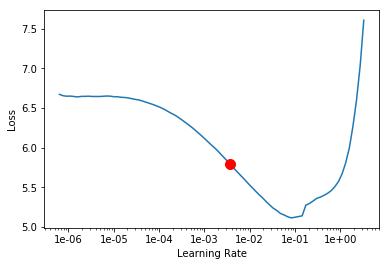

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
len(learn.data.vocab.itos)

1746

In [10]:
#train frozen
print('training frozen')
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy
1,6.035599,5.735363,0.208705


In [11]:
#train unfrozen
print('training unfrozen')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4, moms=(0.8, 0.7))

training unfrozen


epoch,train_loss,valid_loss,accuracy
1,5.450301,4.920609,0.214732
2,4.819039,4.072633,0.283036
3,4.316055,3.738590,0.314955
4,4.000783,3.583597,0.335491
5,3.800292,3.494054,0.340402
6,3.683213,3.428665,0.343304
7,3.606024,3.394099,0.345536
8,3.557494,3.378539,0.347991
9,3.532558,3.374531,0.351786
10,3.518977,3.360912,0.348884


In [13]:
learn.save('truevoice_lm')
learn.save_encoder('truevoice_enc')

### Classification

In [54]:
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=3)]

train_df = pd.read_csv(f'mari_train.csv')
train_df['destination'] = train_df.destination.map(lambda x: x.replace(' ','_'))

data_cls = (TextList.from_df(train_df, model_path, cols=['texts'], processor=processor)
    .random_split_by_pct(valid_pct = 0.05, seed = 1412)
    .label_from_df('destination')
    .add_test(TextList.from_df(test_df, model_path, cols=['texts'], processor=processor))
    .databunch(bs=64)
    )

data_cls.sanity_check()
data_cls.save('truevoice_cls.pkl')

In [55]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(bptt=70, drop_mult=0.5, alpha=2, beta=1)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_func = partial(optim.Adam, betas=(0.7, 0.99))

#load pretrained finetuned model
learn.load_encoder('truevoice_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02


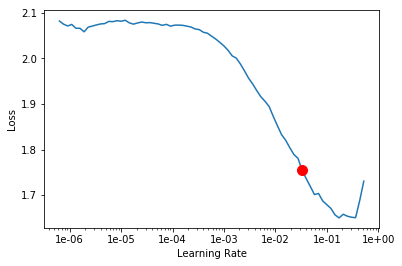

In [20]:
learn.lr_find()
learn.recorder.plot()

In [56]:
#train unfrozen
learn.freeze_to(-1)
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.820964,0.713525,0.743034


In [57]:
#gradual unfreezing
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7), 
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='truevoice_cls')])

epoch,train_loss,valid_loss,accuracy
1,0.589606,0.514945,0.831269


epoch,train_loss,valid_loss,accuracy
1,0.478064,0.432803,0.852941


epoch,train_loss,valid_loss,accuracy
1,0.319146,0.410431,0.876161
2,0.255817,0.391574,0.885449
3,0.166867,0.406172,0.879257


Better model found at epoch 1 with accuracy value: 0.8761609792709351.
Better model found at epoch 2 with accuracy value: 0.8854489326477051.


In [58]:
probs, y_true = learn.get_preds(ds_type = DatasetType.Test, ordered=True)
classes = learn.data.train_ds.classes
y_true = np.array([classes[i] for i in y_true.numpy()])
preds = np.array([classes[i] for i in probs.argmax(1).numpy()])
prob = probs.numpy()

In [59]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

enc_fit = enc.fit(test_df[y][:,None])
pred_ohe = enc_fit.transform(preds[:,None]).toarray()
y_ohe = enc_fit.transform(test_df[y][:,None]).toarray()

In [60]:
import warnings
warnings.filterwarnings("ignore")
#macro metrics
for i in range(nb_class):
    print(
        (pred_ohe[:,i]==y_ohe[:,i]).mean(),
        f1_score(pred_ohe[:,i],y_ohe[:,i]),
        precision_score(pred_ohe[:,i],y_ohe[:,i]),
        recall_score(pred_ohe[:,i],y_ohe[:,i])
         )

0.9313967861557478 0.8852119958634953 0.8761514841351075 0.8944618599791013
0.9585908529048207 0.7276422764227642 0.8817733990147784 0.6193771626297578
0.9400494437577256 0.8450479233226836 0.8601626016260162 0.8304552590266876
0.9898022249690976 0.9185185185185185 0.9489795918367347 0.8899521531100478
0.9057478368355995 0.6765641569459173 0.581056466302368 0.8096446700507615
0.9465389369592089 0.8603712671509282 0.9033898305084745 0.8212634822804314


In [65]:
print('micro metrics')
(preds==test_df[y]).mean(), \
f1_score(test_df[y],preds,average='micro'), \
precision_score(test_df[y],preds,average='micro'), \
recall_score(test_df[y],preds,average='micro')

micro metrics


(0.8349814585908529,
 0.8349814585908529,
 0.8349814585908529,
 0.8349814585908529)